# **Conta Respingo**
Código para processar imagens de protetores faciais com respingos vermelhos. A saída esperada é o manequim e a porcentagem de pontos vermelhos sobre a área total do manequim



### **Dependencias + Abrindo imagens do drive**
> Modo de uso:

1.   Permitir colab que se conecte ao seu drive
2.   Editar caminho p/ abrir imagem desejada
3.   Apertar play em cada bloco de código :)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Tamanho Original: (4632, 3474, 3)
Tamanho Novo: (463, 347, 3)


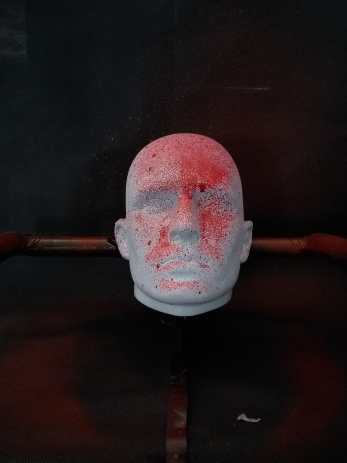

In [ ]:
import cv2          #openCV - biblioteca p/ manipular imagens
import numpy as np  #numpy  - biblioteca p/ manipulação de vetores/matrizes 
from google.colab import drive   #drive  - biblioteca p/ abrir arquivos do drive
from google.colab.patches import cv2_imshow #equivalente a cv2.imshow p/ o google colab

##Abrindo imagens do drive - troque o endereço da funcao imread caso queira abrir outra imagem##
drive.mount('/content/drive')
img = cv2.imread('/content/drive/My Drive/Projeto Protetores Faciais Unesp/Sessao 1/ZERO_0.jpg', 1)  #modo 1 = le imagens coloridas

width = round(img.shape[1] * 0.10)
height = round(img.shape[0] * 0.10)

#diminuindo tamanho da imagem original p/ melhor visualização
print("Tamanho Original:", img.shape)
img = cv2.resize(img, (width,height), interpolation = cv2.INTER_AREA)
print("Tamanho Novo:",img.shape)

cv2_imshow(img)

###**Funções para Pré-Processamento**
* fill_holes
> Preenche o fundo de uma imagem binararia com valores 0. Auxilia na criação de uma mascara binária com somente a região do manequim branca e o restante preto

* edge_detection
> Utiliza filtro de canny para detectar bordas, a imagem resultante auxilia para encontrar a região de interesse (roi) 

* find_roi
> Com auxilio da imagem resultante de edge_detection. Localiza região do rosto do manequim com a função "find_contours", deixando somente o contorno de maior área como roi. A saída esperada é a região do rosto do manequim com o fundo preto.

In [ ]:
def fill_holes(img):
  #"aumentando" tamanho da borda tendo certeza que o contorno eh fechado
  kernel = np.ones((3,3), np.uint8)
  img = cv2.dilate(img, kernel, iterations=2)
  img = cv2.erode(img, kernel, iterations=1)

  print("Entrada Fill Holes")
  cv2_imshow(img)
  h = img.shape[0]
  w = img.shape[1]

  #copia da imagem original e mascara com valores 1 
  flood_img = img.copy()
  fill_mask = np.zeros((h+2, w+2), np.uint8)

	#preenche com branco buracos da img a partir do ponto 0,0
  cv2.floodFill(img, fill_mask, (0,0), 255)
  flood_inv = cv2.bitwise_not(img)

  mask = flood_inv | flood_img 	#mascara final com somente o rosto

  kernel = np.ones((3,3), np.uint8)
  mask = cv2.erode(mask, kernel, iterations=2)
  print("Saida fill_holes")

  cv2_imshow(mask)

	
  return mask

#deteccao de bordas com o filtro de canny
#ref: https://www.sicara.ai/blog/2019-03-12-edge-detection-in-opencv
def edge_detection(frame):
  fgbg = cv2.createBackgroundSubtractorMOG2(
  history=10,
  varThreshold=2,
  detectShadows=False)

  # Convertendo pra escala cinza
  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
	
	#extrai o fundo
  edges_foreground = cv2.bilateralFilter(gray, 9, 75, 75)
  foreground = fgbg.apply(edges_foreground)

  # Smooth out to get the moving area
  kernel = np.ones((50,50),np.uint8)
  foreground = cv2.morphologyEx(foreground, cv2.MORPH_CLOSE, kernel)

	# Applying static edge extraction
  edges_foreground = cv2.bilateralFilter(gray, 9, 75, 75)
  edges_filtered = cv2.Canny(edges_foreground, 60, 120)

	# Crop off the edges out of the moving area
  cropped = (foreground // 255) * edges_filtered

  return cropped

def find_roi(original_img, mask):
  #encontra contornos na imagem de entrada
  contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  print("Contornos encontrados:", len(contours))

  #separa maior contorno
  rois = []
  maior_contorno = contours[0]
  for cnt in contours:
    if(cv2.contourArea(cnt) > cv2.contourArea(maior_contorno)):
      maior_contorno = cnt
  
  print("Maior Contorno:",cv2.contourArea(maior_contorno))
 
  #calcula retangulo em volta do maior contorno
  x,y,w,h = cv2.boundingRect(maior_contorno)
  roi = original_img[y:y+h, x:x+w]  			#recorto imagem original e tenho roi com somente o rosto

  mask = mask[y - 5:y+h+5, x - 5:x+w+5]		#recorte da mascara com folga
  mask = fill_holes(mask) 					      #preenche mascara com valor branco no manequim e preto no fundo

  #redimensionando mascara para "tamanho original"
  h = mask.shape[0]
  w = mask.shape[1]
  mask = mask[5:h-5, 5:w-5]					
	
  #"multiplicando" roi pela mascara, assim somente a regiao do manequim é mantida o resto vira preto
  roi = cv2.bitwise_and(roi,roi, mask=mask)
 
  print("ROI - funcao find_roi")
  cv2_imshow(roi)

  #retorna roi e nova mascara
  return roi, mask

###**Funções de Segmentação por Cor**

* red_filter
> Filtra somente pontos que estejam no intervalo de cor próximo ao vermelho/rosa

* count_red
> Recebe uma imagem e uma mascara (imagem binária) para a região de interesse da imagem. Utiliza a funcao red_filter e usa a imagem de saída para calcular o total de pontos vermelhos. A máscara é usada para calcular o total de pixels que compoe a região de interesse

In [ ]:
#recebe imagem e retorna imagem somente com os pontos vermelhos
def red_filter(img):
  hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

  #valores vermelho/rosa no espaco hsv
  lower_red = (0,50,0)
  upper_red = (30,255,255)

  lower_red2 = (150,50,0)
  upper_red2 = (180,255,255)

  #separando somente pixels dentre a faixa do vermelho/rosa
  red_mask1 = cv2.inRange(hsv_img, lower_red, upper_red)
  red_mask2 = cv2.inRange(hsv_img, lower_red2, upper_red2)
	
  #somando duas mascaras e multiplicando pela imagem
  all_red_mask = red_mask1 + red_mask2
  red_img = cv2.bitwise_and(img, img, mask=all_red_mask)

  print("Imagem somente com pontos vermelhos")
  cv2_imshow(red_img)

  return red_img

#"conta" total de pixels vermelhos
def count_red(img, mask):
  #retorna imagem somente com pixels vermelhos
  red_img = red_filter(img)

  #conta total de pontos pertencentes a cabeca do manequim
  head_area = cv2.countNonZero(mask)

  #aplicando threshold p/ contar pixels vermelhos
  red_img = cv2.cvtColor(red_img, cv2.COLOR_BGR2GRAY)
  ret, th_red_img = cv2.threshold(red_img, 30, 255, 0)

  print("threshold imagem vermelha")
  cv2_imshow(th_red_img)
  red_area = cv2.countNonZero(th_red_img)

  print("Red Area:", red_area)
  print("Area manequim:", head_area)
  total_area = (red_area/head_area) * 100

  print("AREA CALCULADA:", total_area)

  #convertendo p/ string e deixando somente 2 casas decimais
  total_area = format(total_area, '.2f')

  return total_area

###**Função Main**



> Responsável por chamar todas as outras fuções. Aqui o pipeline é construido e a magia acontece :)

---

* **Importante:** Antes de executar tenha certeza que deu play em todas as 
outras células de código, inclusive as mais acima no inicio do documento



Imagem Original


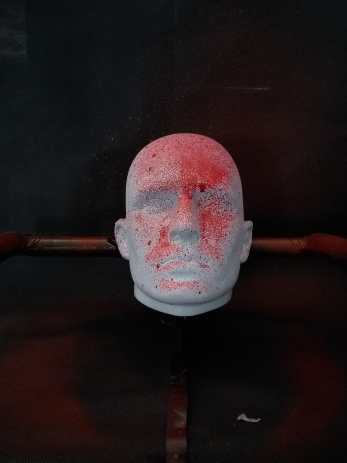

Contornos encontrados: 7
Maior Contorno: 19301.5
Entrada Fill Holes


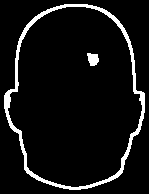

Saida fill_holes


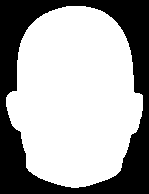

ROI - funcao find_roi


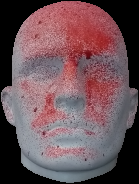

Imagem somente com pontos vermelhos


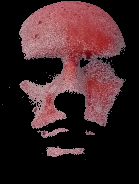

threshold imagem vermelha


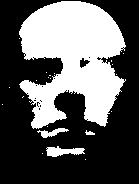

Red Area: 9367
Area manequim: 18907
AREA CALCULADA: 49.54249748770297
Imagem Final


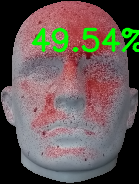

In [ ]:
def main():
	#imagens p/ testes
	# img = cv2.imread("./fotos_s1/MOD_A_0.jpg")    #nada de vermelho
	# img = cv2.imread("./fotos_s1/ZERO_0.jpg")	    #muito vermelho

	# img = cv2.imread("./fotos_s1/MOD_C_45.jpg")   #bastante vermelho
	# img = cv2.imread("./fotos_s1/MOD_B_45.jpg")   #pouco vermelho

	#imagens dificeis
	# img = cv2.imread("./fotos_s1/MOD_A_45.jpg")
	# img = cv2.imread("./fotos_s1/MOD_A_90.jpg")
	# img = cv2.imread("./fotos_s1/MOD_B_90.jpg")

  print("Imagem Original")
  cv2_imshow(img)
	#deteccao de bordas ussando filtro de canny, usado p/ detectar rosto 
  canny = edge_detection(img)

  #realce e reducao de ruido no canny
  kernel = np.ones((3,3), np.uint8)
  canny = cv2.morphologyEx(canny, cv2.MORPH_CLOSE, kernel)

  #encontra roi e retorna roi da img original + mascara nova
  roi, mask = find_roi(img, canny)

  #conta area ocupada pelo vermelho no manequim
  total_area = count_red(roi, mask)
  total_area = total_area + '%'
	
  #escrevendo area total na imagem de entrada
  font = cv2.FONT_HERSHEY_SIMPLEX
  cv2.putText(roi, total_area, (30,50), font, 1, (0,255,0), 2, cv2.LINE_AA)
  print("Imagem Final")
  cv2_imshow(roi)

	#salvando imagem com o resultado -- comentado por estar no google colab
	# img_name2 = img_name.split("/")[2] 
	# dir_name = img_name.split("/")[1]
	# print(dir_name + "/result_" + img_name2)
	# cv2.imwrite(dir_name + "/result_" + img_name2, roi)
	# cv2.waitKey(0)

if(__name__ == '__main__'):
	main()